In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

# Downloading and unziping dermnet dataset

In [5]:
! kaggle datasets download shubhamgoel27/dermnet

100% 1.72G/1.72G [00:13<00:00, 187MB/s]
100% 1.72G/1.72G [00:13<00:00, 137MB/s]


In [6]:
! unzip dermnet.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-8.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-80.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-9.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-100.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-101.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-102.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-103.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-104.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-105.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-106.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthom

# Showing some images from dataset

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
BATCH_SIZE = 64
IMAGE_SIZE = 128
train_path = "/content/train"
test_path = "/content/test"

In [10]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR,IMAGE_SIZE,BATCH_SIZE):
  train_datagen = ImageDataGenerator(rescale=(1/255),
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE))

  test_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=BATCH_SIZE,
                                                                class_mode='categorical',
                                                                target_size=(IMAGE_SIZE, IMAGE_SIZE))
  ### END CODE HERE
  return train_generator, test_generator


In [11]:
train_generator,test_generator=train_val_generators(train_path, test_path,IMAGE_SIZE,BATCH_SIZE)

Found 15557 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


(64, 128, 128, 3)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


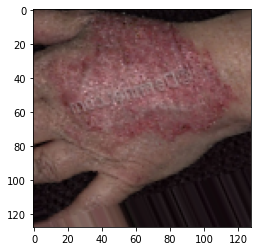

(64, 128, 128, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


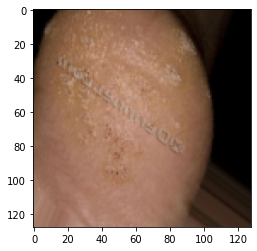

(64, 128, 128, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


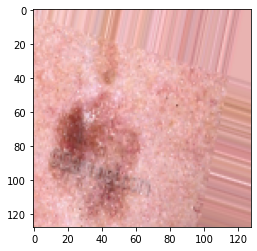

(64, 128, 128, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


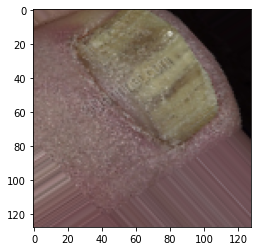

(64, 128, 128, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


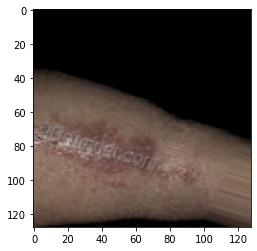

In [12]:
#ploting versi image generator
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [13]:
#class names pakek image generator
class_names = train_generator.class_indices
class_names

{'Acne and Rosacea Photos': 0,
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1,
 'Atopic Dermatitis Photos': 2,
 'Bullous Disease Photos': 3,
 'Cellulitis Impetigo and other Bacterial Infections': 4,
 'Eczema Photos': 5,
 'Exanthems and Drug Eruptions': 6,
 'Hair Loss Photos Alopecia and other Hair Diseases': 7,
 'Herpes HPV and other STDs Photos': 8,
 'Light Diseases and Disorders of Pigmentation': 9,
 'Lupus and other Connective Tissue diseases': 10,
 'Melanoma Skin Cancer Nevi and Moles': 11,
 'Nail Fungus and other Nail Disease': 12,
 'Poison Ivy Photos and other Contact Dermatitis': 13,
 'Psoriasis pictures Lichen Planus and related diseases': 14,
 'Scabies Lyme Disease and other Infestations and Bites': 15,
 'Seborrheic Keratoses and other Benign Tumors': 16,
 'Systemic Disease': 17,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 18,
 'Urticaria Hives': 19,
 'Vascular Tumors': 20,
 'Vasculitis Photos': 21,
 'Warts Molluscum and other Viral Inf

In [14]:
NUMBER_OF_CLASSES = len(class_names)
print(f'number of classes : {NUMBER_OF_CLASSES}')

number of classes : 23


# Creating model

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [17]:
#model compile buat image generator,karena ga bisa pakek sparse
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
    )

In [ ]:
#model fit pakek image generator
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=test_generator)

Epoch 1/100
244/244 [==============================] - 597s 2s/step - loss: 2.9273 - accuracy: 0.1205 - val_loss: 2.8665 - val_accuracy: 0.1387
Epoch 2/100
244/244 [==============================] - 592s 2s/step - loss: 2.8377 - accuracy: 0.1584 - val_loss: 2.7853 - val_accuracy: 0.1619
Epoch 3/100
244/244 [==============================] - 592s 2s/step - loss: 2.7668 - accuracy: 0.1779 - val_loss: 2.7142 - val_accuracy: 0.1884
Epoch 4/100
244/244 [==============================] - 597s 2s/step - loss: 2.7095 - accuracy: 0.1937 - val_loss: 2.6810 - val_accuracy: 0.1982
Epoch 5/100
244/244 [==============================] - 602s 2s/step - loss: 2.6582 - accuracy: 0.2092 - val_loss: 2.6524 - val_accuracy: 0.2139
Epoch 6/100
244/244 [==============================] - 602s 2s/step - loss: 2.6102 - accuracy: 0.2232 - val_loss: 2.6210 - val_accuracy: 0.2299
Epoch 7/100
244/244 [==============================] - 604s 2s/step - loss: 2.5764 - accuracy: 0.2283 - val_loss: 2.5634 - val_accuracy: